- This notebook is for training the model for predicting the column "lights" while it is considered as categorical data, with "epochs = 100, batch_size = 512".

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random as rn
import tensorflow as tf

from keras import backend as K
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.models import load_model
from keras.layers import LSTM
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
# prepare the functions for evaluating the model
def mse(ar1, ar2):
    return ((ar1 - ar2) ** 2).mean()

def rmse(ar1, ar2):
    return np.sqrt(mse(ar1, ar2))

In [3]:
# make the results reproducible
os.environ["PYTHONHASHSEED"] = '0'
np.random.seed(1)
rn.seed(2)
tf.set_random_seed(3)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [4]:
# loading and preprocessing data
energydata_complete = pd.read_csv("energydata_complete.csv").iloc[:, 1:]

energydata_complete = energydata_complete.drop(['Appliances'], axis=1)

Y = energydata_complete.iloc[:, 0].values

labelencoder_Y_1 = LabelEncoder()
Y_labled = labelencoder_Y_1.fit_transform(Y)

onehotencoder = OneHotEncoder(categorical_features = [0])
Y_onehot = onehotencoder.fit_transform(Y_labled.reshape(Y_labled.shape[0], 1)).toarray()
print(Y_onehot)

Y_columnnames = []
for i in range(Y_onehot.shape[1]):
    if i < 10:
        Y_columnnames.append("Y1_0{0}".format(i))
    else:
        Y_columnnames.append("Y1_{0}".format(i))

Y_onehot = pd.DataFrame(Y_onehot, columns = Y_columnnames)

sc = MinMaxScaler(feature_range = (0, 1))
variables_scaled = pd.DataFrame(sc.fit_transform(energydata_complete.iloc[:, 1:]), columns = list(energydata_complete.iloc[:, 1:].columns))
print(variables_scaled.head())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
        T1      RH_1        T2      RH_2        T3      RH_3        T4  \
0  0.32735  0.566187  0.225345  0.684038  0.215188  0.746066  0.351351   
1  0.32735  0.541326  0.225345  0.682140  0.215188  0.748871  0.351351   
2  0.32735  0.530502  0.225345  0.679445  0.215188  0.755569  0.344745   
3  0.32735  0.524080  0.225345  0.678414  0.215188  0.758685  0.341441   
4  0.32735  0.531419  0.225345  0.676727  0.215188  0.758685  0.341441   

       RH_4        T5      RH_5    ...           T9      RH_9     T_out  \
0  0.764262  0.175506  0.381691    ...     0.223032  0.677290  0.372990   
1  0.782437  0.175506  0.381691    ...     0.226500  0.678532  0.369239   
2  0.778062  0.175506  0.380037    ...     0.219563  0.676049  0.365488   
3  0.770949  0.175506  0.380037    ...     0.219563  0.671909  0.361736   
4  0.762697  0.178691  0

d:\programfilesnospace\miniconda3\envs\py365-tfgpu\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
d:\programfilesnospace\miniconda3\envs\py365-tfgpu\lib\site-packages\sklearn\preprocessing\_encoders.py:385: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [5]:
# separate the data into training set and testing set
X_train_scaled = variables_scaled.iloc[:round(np.shape(variables_scaled)[0] * 0.8), :]
Y_train_encoded = Y_onehot.iloc[:round(np.shape(Y_onehot)[0] * 0.8), :]

X_test_scaled = variables_scaled.iloc[round(np.shape(variables_scaled)[0] * 0.8):, :]
Y_test_encoded = Y_onehot.iloc[round(np.shape(Y_onehot)[0] * 0.8):, :]

X_train_scaled = np.reshape(X_train_scaled.values, (X_train_scaled.values.shape[0], X_train_scaled.values.shape[1], 1))
X_test_scaled = np.reshape(X_test_scaled.values, (X_test_scaled.values.shape[0], X_test_scaled.values.shape[1], 1))

In [6]:
# Initialising the RNN
layers = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
layers.add(LSTM(units = 16, return_sequences = True, input_shape = (X_train_scaled.shape[1], 1)))
layers.add(Dropout(0.2))

layers.add(Flatten())

# Adding the output layer
layers.add(Dense(Y_train_encoded.shape[1], activation='softmax'))

layers.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/100
15788/15788 [==============================] - 2s 135us/step - loss: 1.1885 - acc: 0.7109
Epoch 2/100
15788/15788 [==============================] - 1s 93us/step - loss: 0.8762 - acc: 0.7432
Epoch 3/100
15788/15788 [==============================] - 1s 82us/step - loss: 0.8649 - acc: 0.7432
Epoch 4/100
15788/15788 [==============================] - 1s 79us/step - loss: 0.8598 - acc: 0.7432
Epoch 5/100
15788/15788 [==============================] - 1s 79us/step - loss: 0.8562 - acc: 0.7432
Epoch 6/100
15788/15788 [==============================] - 1s 80us/step - loss: 0.8528 - acc: 0.7432
Epoch 7/100
15788/15788 [==============================] - 1s 79us/step - loss: 0.8486 - acc: 0.7432
Epoch 8/100
15788/15788 [==============================] - 1s 79us/step - loss: 0.8472 - acc: 0.7432
Epoch 9/100
15788/15788 [==============================] - 1s 79us/step - loss: 0.8429 - acc: 0.7432
Epoch 10/100
15788/15788 [==============================] - 1s 80us/step - loss: 0.8406 - 

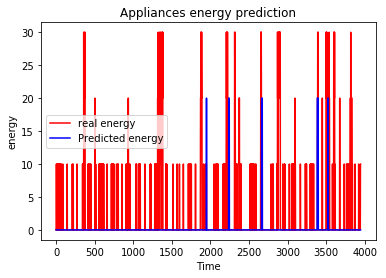

In [7]:
# all the following code will be executed manually for every iteration
layers.fit(X_train_scaled, Y_train_encoded, epochs = 100, batch_size = 512)

# layers.save('layers2_1.h5')  # creates a HDF5 file 'my_model.h5'
# layers = load_model('layers2_1.h5')

predicted_energy = layers.predict(X_test_scaled)
accuracy = sum(np.argmax(predicted_energy, axis = 1) == np.argmax(Y_test_encoded.values, axis = 1)) / len(Y_test_encoded.values)
print("The accuracy(categorical) is: {0}".format(accuracy))

predicted_energy_inversed = labelencoder_Y_1.inverse_transform(np.argmax(predicted_energy, axis = 1))
predicted_mse = mse(predicted_energy_inversed, Y[round(np.shape(Y)[0] * 0.8):])
print("The mean squared error is: {0}".format(predicted_mse))

plt.plot(Y[round(np.shape(Y)[0] * 0.8):], color = 'red', label = 'real energy')
plt.plot(predicted_energy_inversed, color = 'blue', label = 'Predicted energy')
plt.title('Appliances energy prediction')
plt.xlabel('Time')
plt.ylabel('energy')
plt.legend()
plt.show()

Epoch 1/100
15788/15788 [==============================] - 2s 106us/step - loss: 0.7239 - acc: 0.7589
Epoch 2/100
15788/15788 [==============================] - 1s 80us/step - loss: 0.7247 - acc: 0.7594
Epoch 3/100
15788/15788 [==============================] - 1s 79us/step - loss: 0.7257 - acc: 0.7579
Epoch 4/100
15788/15788 [==============================] - 1s 81us/step - loss: 0.7223 - acc: 0.7610
Epoch 5/100
15788/15788 [==============================] - 1s 80us/step - loss: 0.7240 - acc: 0.7585
Epoch 6/100
15788/15788 [==============================] - 1s 92us/step - loss: 0.7212 - acc: 0.7595
Epoch 7/100
15788/15788 [==============================] - 1s 80us/step - loss: 0.7216 - acc: 0.7586
Epoch 8/100
15788/15788 [==============================] - 1s 82us/step - loss: 0.7200 - acc: 0.7610
Epoch 9/100
15788/15788 [==============================] - 1s 82us/step - loss: 0.7210 - acc: 0.7616
Epoch 10/100
15788/15788 [==============================] - 1s 80us/step - loss: 0.7186 - 

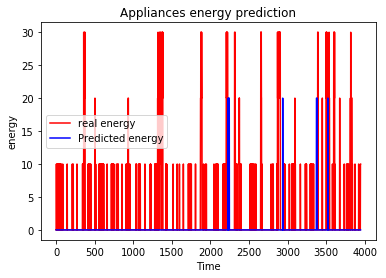

In [8]:
# all the following code will be executed manually for every iteration
layers.fit(X_train_scaled, Y_train_encoded, epochs = 100, batch_size = 512)

# layers.save('layers2_1.h5')  # creates a HDF5 file 'my_model.h5'
# layers = load_model('layers2_1.h5')

predicted_energy = layers.predict(X_test_scaled)
accuracy = sum(np.argmax(predicted_energy, axis = 1) == np.argmax(Y_test_encoded.values, axis = 1)) / len(Y_test_encoded.values)
print("The accuracy(categorical) is: {0}".format(accuracy))

predicted_energy_inversed = labelencoder_Y_1.inverse_transform(np.argmax(predicted_energy, axis = 1))
predicted_mse = mse(predicted_energy_inversed, Y[round(np.shape(Y)[0] * 0.8):])
print("The mean squared error is: {0}".format(predicted_mse))

plt.plot(Y[round(np.shape(Y)[0] * 0.8):], color = 'red', label = 'real energy')
plt.plot(predicted_energy_inversed, color = 'blue', label = 'Predicted energy')
plt.title('Appliances energy prediction')
plt.xlabel('Time')
plt.ylabel('energy')
plt.legend()
plt.show()

Epoch 1/100
15788/15788 [==============================] - 2s 105us/step - loss: 0.6926 - acc: 0.7656
Epoch 2/100
15788/15788 [==============================] - 1s 80us/step - loss: 0.6966 - acc: 0.7638
Epoch 3/100
15788/15788 [==============================] - 1s 79us/step - loss: 0.6936 - acc: 0.7654
Epoch 4/100
15788/15788 [==============================] - 1s 79us/step - loss: 0.6927 - acc: 0.7649
Epoch 5/100
15788/15788 [==============================] - 1s 79us/step - loss: 0.6942 - acc: 0.7641
Epoch 6/100
15788/15788 [==============================] - 1s 79us/step - loss: 0.6947 - acc: 0.7647
Epoch 7/100
15788/15788 [==============================] - 1s 80us/step - loss: 0.6945 - acc: 0.7618
Epoch 8/100
15788/15788 [==============================] - 1s 79us/step - loss: 0.6912 - acc: 0.7651
Epoch 9/100
15788/15788 [==============================] - 1s 80us/step - loss: 0.6954 - acc: 0.7639
Epoch 10/100
15788/15788 [==============================] - 1s 79us/step - loss: 0.6940 - 

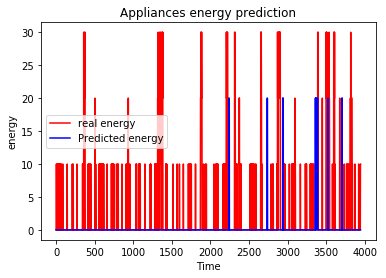

In [9]:
# all the following code will be executed manually for every iteration
layers.fit(X_train_scaled, Y_train_encoded, epochs = 100, batch_size = 512)

# layers.save('layers2_1.h5')  # creates a HDF5 file 'my_model.h5'
# layers = load_model('layers2_1.h5')

predicted_energy = layers.predict(X_test_scaled)
accuracy = sum(np.argmax(predicted_energy, axis = 1) == np.argmax(Y_test_encoded.values, axis = 1)) / len(Y_test_encoded.values)
print("The accuracy(categorical) is: {0}".format(accuracy))

predicted_energy_inversed = labelencoder_Y_1.inverse_transform(np.argmax(predicted_energy, axis = 1))
predicted_mse = mse(predicted_energy_inversed, Y[round(np.shape(Y)[0] * 0.8):])
print("The mean squared error is: {0}".format(predicted_mse))

plt.plot(Y[round(np.shape(Y)[0] * 0.8):], color = 'red', label = 'real energy')
plt.plot(predicted_energy_inversed, color = 'blue', label = 'Predicted energy')
plt.title('Appliances energy prediction')
plt.xlabel('Time')
plt.ylabel('energy')
plt.legend()
plt.show()

Epoch 1/100
15788/15788 [==============================] - 1s 80us/step - loss: 0.6731 - acc: 0.7694
Epoch 2/100
15788/15788 [==============================] - 1s 79us/step - loss: 0.6748 - acc: 0.7705
Epoch 3/100
15788/15788 [==============================] - 1s 79us/step - loss: 0.6731 - acc: 0.7691
Epoch 4/100
15788/15788 [==============================] - 1s 79us/step - loss: 0.6735 - acc: 0.7686
Epoch 5/100
15788/15788 [==============================] - 1s 80us/step - loss: 0.6749 - acc: 0.7708
Epoch 6/100
15788/15788 [==============================] - 1s 80us/step - loss: 0.6725 - acc: 0.7705
Epoch 7/100
15788/15788 [==============================] - 1s 80us/step - loss: 0.6730 - acc: 0.7681
Epoch 8/100
15788/15788 [==============================] - 2s 97us/step - loss: 0.6762 - acc: 0.7691
Epoch 9/100
15788/15788 [==============================] - 2s 95us/step - loss: 0.6744 - acc: 0.7681
Epoch 10/100
15788/15788 [==============================] - 1s 94us/step - loss: 0.6745 - a

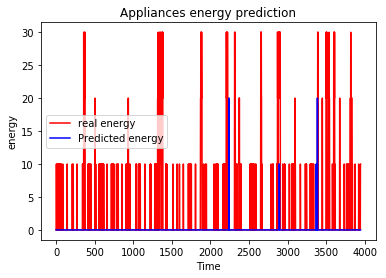

In [10]:
# all the following code will be executed manually for every iteration
layers.fit(X_train_scaled, Y_train_encoded, epochs = 100, batch_size = 512)

# layers.save('layers2_1.h5')  # creates a HDF5 file 'my_model.h5'
# layers = load_model('layers2_1.h5')

predicted_energy = layers.predict(X_test_scaled)
accuracy = sum(np.argmax(predicted_energy, axis = 1) == np.argmax(Y_test_encoded.values, axis = 1)) / len(Y_test_encoded.values)
print("The accuracy(categorical) is: {0}".format(accuracy))

predicted_energy_inversed = labelencoder_Y_1.inverse_transform(np.argmax(predicted_energy, axis = 1))
predicted_mse = mse(predicted_energy_inversed, Y[round(np.shape(Y)[0] * 0.8):])
print("The mean squared error is: {0}".format(predicted_mse))

plt.plot(Y[round(np.shape(Y)[0] * 0.8):], color = 'red', label = 'real energy')
plt.plot(predicted_energy_inversed, color = 'blue', label = 'Predicted energy')
plt.title('Appliances energy prediction')
plt.xlabel('Time')
plt.ylabel('energy')
plt.legend()
plt.show()

- We thought there may be some kinds of overfitting. So, we turned down the step of iteration with “epochs=100”, “batch_size=512” for each. But the result didn’t change too much. We checked the code for a while, still found nothing wrong.
- Finally, after checked the data again, we realized that the data is not balanced, it is biased. In short, about 77% of the values in column “lights” is zero. That means in most cases, when we build the model with this dataset, the value in that column can be easily predicted when true values are zeros, while provide less guarantee for other values. On the other hand, considering the previous graphs, there are more than 3000 records in a single graph, and the red vertical lines we saw is just a small portion of the values. Although the images are misleading, from the accuracy and mean squared error, we can see that the result is still acceptable.